In [2]:
import requests as rq
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import clear_output

In [2]:
datasets = {
  # "raw_data.csv" : "https://drive.google.com/uc?export=download&id=1FKbK6q16Vf3yOOvcMAgFhZIjQcc2XxGZ",

  # "all_data.csv" : "https://drive.google.com/uc?export=download&id=1jea08IR2edlwOl-gERZOtNLdbi5U3nor",

  "y_test.csv" : "https://www.dropbox.com/scl/fi/3c7br6x2k0lo6iujtwzt0/y_test.csv?rlkey=9rlywjvoduahpu27uoclmmtqg&st=5hyfuf7b&dl=1",

  "y_train.csv" : "https://www.dropbox.com/scl/fi/n228uag3g0qqdigwlu151/y_train.csv?rlkey=8g2nm1w539t7o84k8jceqfdtz&st=tskbwl6g&dl=1",

  "X_train.csv" : "https://www.dropbox.com/scl/fi/eraukmu5w1r56vigj1bla/X_train.csv?rlkey=gpzrwnvhhk6q07r9nklz09fl1&st=vnux3ves&dl=1",

  "X_test.csv" : "https://www.dropbox.com/scl/fi/a4dlgfke5swfjkolikr5o/X_test.csv?rlkey=2u02d3zmy0ls59katzrwljpgq&st=w6w9egec&dl=1"
}


In [3]:
import requests
import pandas as pd
import os

def get_dataset(url, dataset_name):
    response = requests.get(url)

    with open(dataset_name, 'wb') as file:
        file.write(response.content)

    df = pd.read_csv(dataset_name)
    return df


In [4]:
dfs = {}
for dataset_name, url in datasets.items():
    df = get_dataset(url, dataset_name)
    dfs[dataset_name] = df
    display(df.head())


,category
0,1
1,2
2,0
3,0
4,4


,category
0,1
1,1
2,0
3,7
4,3


,text
0,Фото: Гавриил Григоров / РИА Новости Платон Щу...
1,Фото: Maksim Konstantinov / globallookpress.co...
2,Фото: Марина Молдавская / Коммерсантъ По всей ...
3,Фото: Смольский Сергей / ТАСС Даниил Иринин Ко...
4,Владимир Сальдо Фото: Ona2011 / Wikimedia Алев...


,text
0,Фото: Евгений Биятов / РИА Новости Мария Грушк...
1,Фото: Александр Коряков / Коммерсантъ Любовь Ш...
2,Фото: Evgenia Novozhenina / Reuters Марина Сов...
3,Фото: Vladimir Baranov / Globallook Press Анас...
4,Анна Башта (слева) и Ольга Харлан (справа) Фот...


In [7]:
X_train = dfs['X_train.csv']
X_test = dfs['X_test.csv']
y_test = dfs['y_test.csv']
y_train = dfs['y_train.csv']
# X_train = pd.read_csv('X_train.csv')
# X_test = pd.read_csv('X_test.csv')
# y_train = pd.read_csv('y_train.csv')
# y_test = pd.read_csv('y_test.csv')

In [7]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
def create_cloud_graph(corpus):
    wordcloud = WordCloud(
        width=1600, height=800, max_words=200, background_color='white', collocations=False
    ).generate(' '.join(corpus))
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

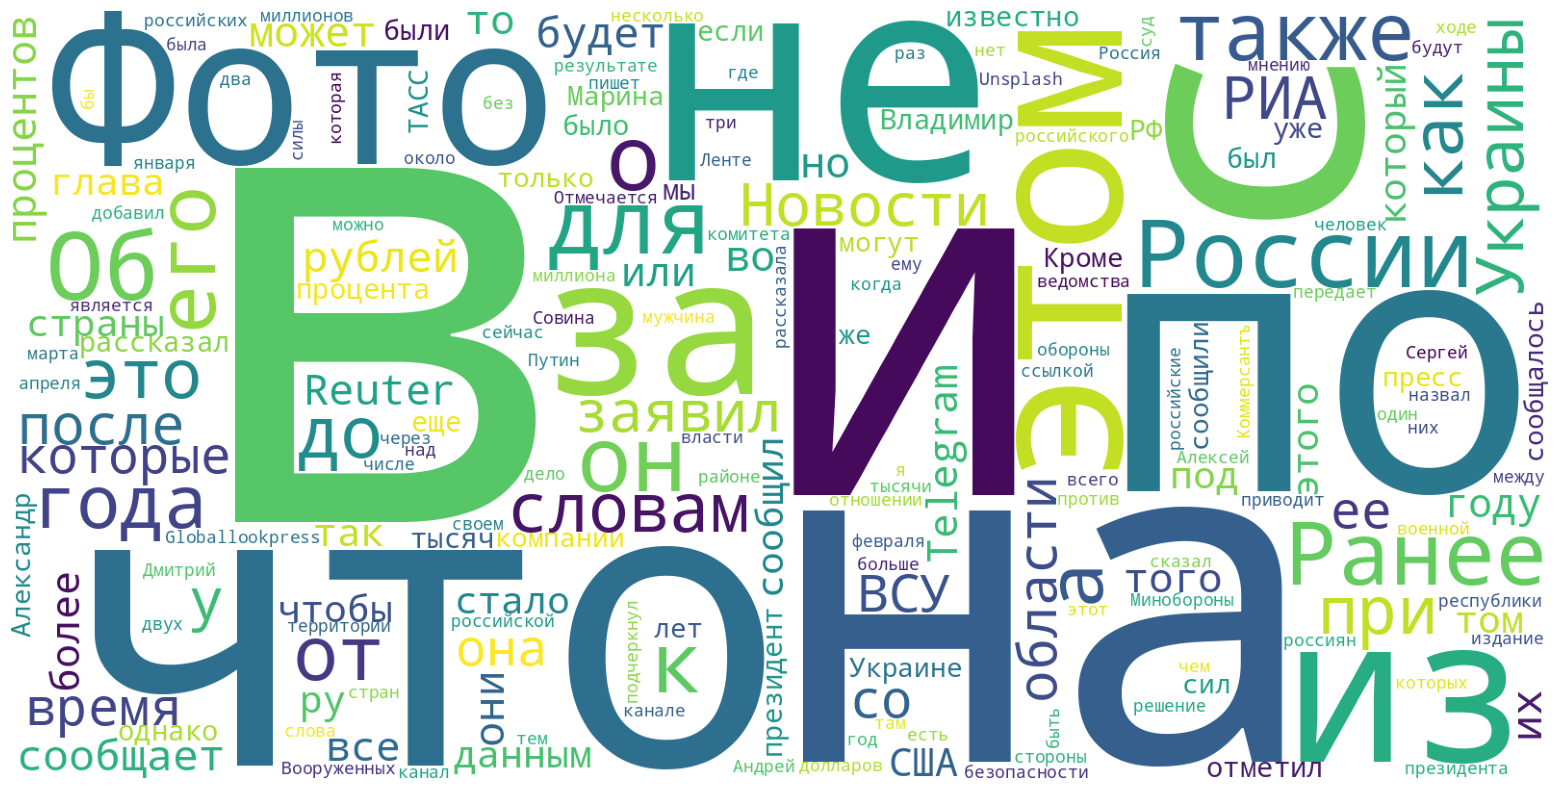

In [8]:
create_cloud_graph(X_train['text'])

Видим, что много слов это местоимения, предлоги и так далее, их уберем позже, когда будем убирать стоп слова

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(min_df=4, max_df=0.95)
bow_vectorizer.fit(X_train['text'])

CountVectorizer(max_df=0.95, min_df=4)

In [10]:
bow_train = bow_vectorizer.transform(X_train['text'])
bow_test = bow_vectorizer.transform(X_test['text'])

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [9]:
def LR(train, test, y_tr, y_test):
    lr = LogisticRegression(max_iter=500)
    lr.fit(train, y_tr)

    train_pred = lr.predict(train)
    test_pred = lr.predict(test)

    train_acc = accuracy_score(y_tr, train_pred)
    test_acc = accuracy_score(y_test, test_pred)

    print('Train accuracy:', round(train_acc, 3))
    print('Test accuracy: ', round(test_acc, 3))

In [13]:
LR(bow_train, bow_test, y_train, y_test)

/home/astasiva/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train accuracy: 1.0
Test accuracy:  0.945


Просто реализовали мешок слов, чтобы перевести текст в векторы чисел

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
tfidf_vectorizer = TfidfVectorizer(min_df=4, max_df=0.95)
tfidf_vectorizer.fit(X_train['text'])
tfidf_train = tfidf_vectorizer.transform(X_train['text'])
tfidf_test = tfidf_vectorizer.transform(X_test['text'])

In [16]:
LR(tfidf_train, tfidf_test, y_train, y_test)

/home/astasiva/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train accuracy: 0.968
Test accuracy:  0.947


Отрезали слишком редкие слова и слишком частые, которые встречаются чаще 95% случаев

In [13]:
import re
from string import punctuation
from nltk.tokenize import wordpunct_tokenize
def tokenize(text):
    reg = re.compile(r'\w+')
    return reg.findall(text)

In [14]:
data_tok_train = [tokenize(t.lower()) for t in X_train['text']]
data_tok_test = [tokenize(t.lower()) for t in X_test['text']]

In [5]:
print(data_tok_train[:2])

[['фото', 'гавриил', 'григоров', 'риа', 'новости', 'платон', 'щукин', 'традиционная', 'отдельная', 'встреча', 'президента', 'россии', 'владимира', 'путина', 'с', 'главами', 'крупных', 'компаний', 'в', 'рамках', 'петербургского', 'международного', 'экономического', 'форума', 'пмэф', '2023', 'не', 'планируется', 'об', 'этом', 'заявил', 'глава', 'российского', 'союза', 'промышленников', 'и', 'предпринимателей', 'рспп', 'александр', 'шохин', 'передает', 'тасс', 'по', 'его', 'мнению', 'отсутствие', 'такого', 'мероприятия', 'в', 'расписании', 'главы', 'государства', 'связано', 'с', 'тем', 'что', 'первые', 'лица', 'крупнейших', 'международных', 'компаний', 'не', 'хотят', 'принимать', 'в', 'нем', 'участие', 'шохин', 'подчеркнул', 'что', 'встреча', 'могла', 'бы', 'нанести', 'ущерб', 'бизнесменам', 'продолжающим', 'работу', 'в', 'стране', 'те', 'кто', 'продолжают', 'работать', 'в', 'россии', 'не', 'хотят', 'попадать', 'под', 'радары', 'своих', 'контролирующих', 'органов', 'с', 'тем', 'чтобы', 'н

In [15]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

stop_words = stopwords.words('russian')
stop_words += ['фото', 'com', 'ru']
print(stop_words)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

[nltk_data] Downloading package stopwords to /home/alex/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
def remove_stopwords(tokenized_texts):
    clear_texts = []
    for words in tokenized_texts:
        clear_texts.append([word for word in words if word not in stop_words])

    return clear_texts

In [17]:
data_tok_train = remove_stopwords(data_tok_train)
data_tok_test = remove_stopwords(data_tok_test)

In [9]:
print(X_train['text'].iloc[50])
print(data_tok_train[50])

Фото: Виталий Аньков / РИА Новости Платон Щукин По итогам 2022 года самой дефицитной профессией в России стал токарь. Как следует из результатов исследования кадрового сервиса hh.ru, на каждую соответствующую вакансию приходилось всего 0,6 резюме, передает РБК. Также работодателям перестало хватать дворников и врачей (0,8 отзыва на вакансию), главных врачей и заведующих отделением (0,9), машинистов и агрономов (1), слесарей и поваров (1,1) зоотехников и сварщиков (1,2). Наибольшей популярностью у соискателей пользуются профессии бортпроводника (более 900 резюме на вакансию), дата-сайентисты (90), механики (55,7), бизнес-аналитики (49,4), лаборанты (45,8), методисты (45,4), комплаенс-менеджеры (43,7), специалисты по взысканию задолженности (38,5), инженеры ПНР (37,4) и BI-аналитики (36,3). Ранее hh.ru подсчитал, что самой востребованной профессией в 2022 году стал менеджер по продажам — на сервисе было опубликовало 497 тысяч вакансий. Второе место заняли продавцы-консультанты (467 тысяч

Удалили стоп слова, привели все к нижнему регистру

In [38]:
from nltk.stem import SnowballStemmer
from tqdm import tqdm
def stem_text(tokenized_texts):
    stemmed_data = []
    stemmer = SnowballStemmer(language="russian")

    for words in tqdm(tokenized_texts):
        stemmed_words = [stemmer.stem(word) for word in words]
        stemmed_data.append(stemmed_words)
    return stemmed_data

In [ ]:
# stemmed_train = stem_text(data_tok_train)
# stemmed_test = stem_text(data_tok_test)

In [ ]:
# print(data_tok_train[50])
# print(stemmed_train[50])

In [ ]:
# tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, min_df=4)
# tfidf_vectorizer.fit(stemmed_train)
# tfidf_stemmed_train = tfidf_vectorizer.transform(stemmed_train)
# tfidf_stemmed_test = tfidf_vectorizer.transform(stemmed_test)

In [ ]:
# LR(tfidf_stemmed_train, tfidf_stemmed_test, y_train, y_test)

In [22]:
import pymorphy3
from tqdm import tqdm
def lemmatize_text(tokenized_texts):
    lemmatized_data = []
    lemmatizer = pymorphy3.MorphAnalyzer()
    for i, words in enumerate(tqdm(tokenized_texts)):
        lemmatized_words = [lemmatizer.normal_forms(word)[0] for word in words]
        lemmatized_data.append(lemmatized_words)

    return lemmatized_data

In [23]:
lemmatized_train = lemmatize_text(data_tok_train)
lemmatized_test = lemmatize_text(data_tok_test)

100%|██████████| 86670/86670 [08:14<00:00, 175.33it/s]


Нормализовали слова, lemmatizer.normal_forms(word)[0] берем нулевой элемент, поскольку для некоторых слов выдается несколько нормальных форм

In [24]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, min_df=4)
tfidf_vectorizer.fit(lemmatized_train)
tfidf_lemmatized_train = tfidf_vectorizer.transform(lemmatized_train)
tfidf_lemmatized_test = tfidf_vectorizer.transform(lemmatized_test)

/home/alex/anaconda3/envs/dl-mcs/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [25]:
LR(tfidf_lemmatized_train, tfidf_lemmatized_test, y_train, y_test)

/home/alex/anaconda3/envs/dl-mcs/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train accuracy: 0.962
Test accuracy:  0.945


In [27]:
from scipy import sparse

# Сохраняем в .npz (разреженный формат)
sparse.save_npz("tfidf_train_sparse.npz", tfidf_lemmatized_train)
sparse.save_npz("tfidf_test_sparse.npz", tfidf_lemmatized_test)

# Для загрузки обратно:
# tfidf_train = sparse.load_npz("tfidf_train_sparse.npz")
# tfidf_test = sparse.load_npz("tfidf_test_sparse.npz")

In [36]:
from scipy.sparse import vstack
X = vstack([tfidf_lemmatized_train, tfidf_lemmatized_test])
y = np.concatenate([y_train, y_test])

In [28]:
lr = LogisticRegression(max_iter=500)
lr.fit(tfidf_lemmatized_train, y_train)

/home/alex/anaconda3/envs/dl-mcs/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=500)

In [ ]:
def identity_tokenizer(text):
    return text

tfidf_vectorizer = TfidfVectorizer(
    tokenizer=identity_tokenizer,  # Используем именованную функцию вместо lambda
    lowercase=False,
    min_df=4
)
tfidf_vectorizer.fit(lemmatized_train)

In [34]:
from joblib import dump
from sklearn.linear_model import LogisticRegression

# Обучение модели
lr = LogisticRegression(max_iter=500)
lr.fit(X, y)

# Сохранение модели и векторайзера
dump((lr, tfidf_vectorizer), 'logistic_regression_model_2.joblib')

/home/alex/anaconda3/envs/dl-mcs/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['logistic_regression_model.joblib']

In [35]:
from joblib import load

loaded_lr, loaded_vectorizer = load('logistic_regression_model.joblib')
print("Модель и векторайзер успешно загружены!")

Модель и векторайзер успешно загружены!


In [ ]:
dataset = pd.read_csv('/content/test_news.csv')

In [ ]:
data = pd.read_csv('/content/all_data (1).csv')

In [ ]:
y = data['category']

In [ ]:
data = [tokenize(t.lower()) for t in data['text']]
data = remove_stopwords(data)


In [ ]:
lemmatized_data = lemmatize_text(data)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, min_df=4)
tfidf_vectorizer.fit(lemmatized_data)

In [ ]:
dataset = [tokenize(t.lower()) for t in dataset['content']]
dataset = remove_stopwords(dataset)
lemmatized_dataset = lemmatize_text(dataset)
tfidf_lemmatized_dataset = tfidf_vectorizer.transform(lemmatized_dataset)
tfidf_lemmatized_data = tfidf_vectorizer.transform(lemmatized_data)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=100, random_state=239)
RF.fit(tfidf_lemmatized_data, y)


In [ ]:
answer = pd.DataFrame(RF.predict(tfidf_lemmatized_dataset))
answer.to_csv("Random_Forest.csv")

In [ ]:
lr = LogisticRegression(max_iter=500)
lr.fit(tfidf_lemmatized_data, y)

In [ ]:
y_pred = lr.predict(tfidf_lemmatized_dataset)

In [ ]:
y_pred = pd.DataFrame(y_pred)

In [ ]:
y_pred.to_csv('megadata.csv')

Выводы:
Обычная линейная регрессия проявила себя лучше всего, гораздо лучше, чем Random_forest (предсказания уже на каггле проверяла, потому что на моем датасете ОЧЕНЬОЧЕНЬ долго и больно это делать)
Скорее всего, если перебрать модели гридсерчем, то можно добиться и большего качества, но поскольку каждая итерация обучения очень долгая, то кросс-валидацию я не стала реализовывать.